# Data Cleaning and Setup

## CESGA

This notebook marks the beginning of my meteorological forecasting project during my internship at **MeteoGalicia**. My first task was to create a clean and well-structured dataset based on the raw data files provided by my tutors. This step was essential to ensure that the dataset was ready for model training and further analysis.

All data processing and model training were performed remotely on the **CESGA** (*Centro Europeo de Supercomputación de Galicia*) high-performance computing cluster.

To access CESGA, I first established a secure **VPN** connection using the snx command-line utility, which allowed CESGA to identify and authorize my device. Once connected, I used **SSH** to access the cluster and standard Bash commands to navigate directories, manage files, and execute Python scripts.

## Merging our data

Once connected to CESGA facilites, I started polishing the data I had at my disposal. To create a comprehensive dataset, I had to merge multiple compressed files containing hour-by-hour data from a meteorological model alongside observational data collected from various weather stations. Each file represented a different time period or data source, so careful alignment was required to synchronize timestamps and ensure consistency. Below are shown and decompressed the two data packages I had been given:

In [ ]:
%%bash
cd GitHub/dataset/
tar -xvzf estaciones.tar.gz
tar -xvzf wrfout.tar.gz

estaciones.tar.gz contains .csv files from 2008 to 2025 with hourly observational data from various stations across Galicia, while wrfout.tar.gz includes hourly prediction files generated by the WRF (Weather Research and Forecasting) model.

In [ ]:
import glob
import pandas as pd

csv_files = sorted(glob.glob("GitHub/dataset/20*.csv"))

df_combined = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
df_combined.to_csv('Observational_data.csv', index=False)

In [ ]:
import glob
import pandas as pd 
from datetime import datetime, timedelta
import os

csv_files = sorted(glob.glob("GitHub/dataset/wrfout*.csv"))
all_data = []

for file in csv_files:
    # Extract date from filename
    date_str = os.path.basename(file).split('_')[2]  # 'YYYYMMDD' format
    base_datetime = datetime.strptime(date_str, "%Y%m%d")
    
    df = pd.read_csv(file)
    
    # Add hour sequence and datetime column
    df['hour'] = list(range(24)) * (len(df) // 24)
    df['datetime'] = df['hour'].apply(lambda h: base_datetime + timedelta(hours=h))
    
    df.drop(columns='hour', inplace=True)
    all_data.append(df)

# Combine all files
merged_df = pd.concat(all_data, ignore_index=True)
# Save to CSV
merged_df.to_csv("WRF.csv", index=False)

In [2]:
import pandas as pd

obs = pd.read_csv('Observational_data.csv', usecols=['fecha', 'estacion', 'TA'])
obs.rename(columns={'fecha': 'datetime', 'estacion': 'id'}, inplace=True)

wrf = pd.read_csv('WRF.csv')
wrf.drop(columns = ['Time'])
wrf.rename(columns={'estacion': 'id'}, inplace=True)

merged = pd.merge(wrf, obs[['TA','id','datetime']], on=["id", "datetime"], how="inner")
merged.to_csv("DATA.csv", index=False)

## Including new variables

The available data was sufficient to begin developing a model capable of forecasting temperature. However, we identified several missing parameters that could significantly impact the model’s accuracy and decided they were worth adding to our initial dataset. One of these was the percentage of sea surrounding a given location. Although Galicia is not a large region, its weather varies considerably from place to place, which makes our task more challenging. The Atlantic Ocean acts as a thermal reservoir, helping to stabilize coastal temperatures, but its influence decreases as we move inland. We believed that including a parameter representing the sea percentage around each point could improve the model’s accuracy.

In addition to this, we decided to incorporate the latitude, longitude and orography of each location, as well as two variables to represent the hour of the day and the day of the year. Because daily and yearly weather patterns follow periodic cycles, simply providing the model with a numeric hour (e.g., 00:00 to 23:00) or day of the year (1 to 365) would not effectively capture this cyclical nature. To address this, we included two periodic functions: one with a period of 24 hours and another with a period of 365 days, allowing the values to return smoothly to their starting point after a full day or year. This is a common and effective practice in meteorological modeling.

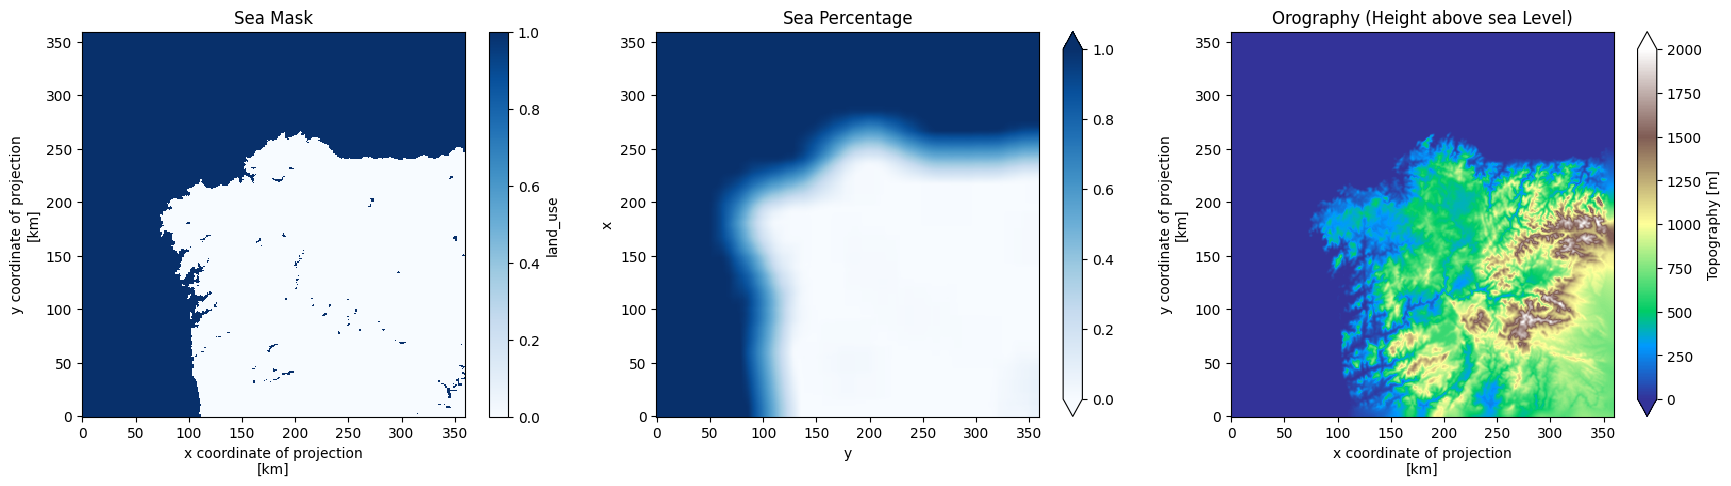

In [22]:
import xarray as xr
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter

url = 'https://mandeo.meteogalicia.es/thredds/dodsC/modelos/WRF_ARW_1KM_HIST_Novo/20250715/wrf_arw_det_history_d02_20250715_0000.nc4' # from MeteoGalicia web database
da = xr.open_dataset(url, engine ='netcdf4')

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(21, 5))

# Sea mask plot
sea = (da.isel(time=0)['land_use'] == 17).astype(int)
sea.plot(ax = axes[0], vmin = 0, vmax = 1 ,cmap = 'Blues')
axes[0].set_title('Sea Mask')
# Sea percentage plot
sea_percentage = uniform_filter(sea.astype(float), size=50) # Up to 25km of distance
sea_percentage = xr.DataArray(sea_percentage, dims = ['x','y'])
sea_percentage.plot(ax=axes[1], vmin = 0, vmax = 1, cmap='Blues')
axes[1].set_title('Sea Percentage')
# Orography plot
da['topo'].isel(time=0).plot(ax = axes[2], vmin = 0, vmax = 2000, cmap='terrain')
axes[2].set_title('Orography (Height above sea Level)')

plt.subplots_adjust(wspace=0.2)




Above, we have presented three complementary maps characterizing distinct features of the Galician territory. The first map provides a binary mask delineating sea and land tiles. Building on this, the second map represents the local sea percentage by calculating the proportion of sea tiles within a moving 25×25 grid window around each location, effectively capturing the degree of marine influence in the immediate surroundings. Finally, the third map illustrates the orographic variability across Galicia, revealing a complex terrain with pronounced mountainous regions inland and comparatively flatter areas along the coastal margin, highlighting the region’s diverse structure.

Now we will add the variables we previously talked about to the existing DataFrame. Incorporating the hour and day variables is straightforward. However, assigning the sea percentage to each station is more involved. The MeteoGalicia dataset provides land use information on a 360x360 grid covering the Galician territory. To estimate the sea percentage at each station, we match each station to the nearest point on this grid. While interpolation would provide a smoother result, it requires well-organized (monotonically increasing) coordinate arrays, but, since the available dataset uses an irregular grid structure, we opted for the nearest-neighbor approach as a reliable alternative.

In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
from scipy.ndimage import uniform_filter
from scipy.spatial import cKDTree

# Load sea/land use data from MeteoGalicia
url = 'https://mandeo.meteogalicia.es/thredds/dodsC/modelos/WRF_ARW_1KM_HIST_Novo/20250715/wrf_arw_det_history_d02_20250715_0000.nc4'
da = xr.open_dataset(url, engine='netcdf4')
da = da.isel(time=0)


# Create sea mask
sea = (da['land_use'] == 17).astype(int)
# Smooth to get sea percentage (approx. 25 km radius)
sea_percentage = uniform_filter(sea.astype(float), size=50)
# Convert to DataArray 
sea_percent = xr.DataArray(
    sea_percentage,
    dims=da['land_use'].dims,
    coords=da['land_use'].coords,
    name='sea_percent'
)


# Extract 2D lat/lon arrays
lat2d = sea_percent['lat'].values  
lon2d = sea_percent['lon'].values  
# Flatten to (N, 2) array for KDTree
grid_points = np.column_stack((lat2d.ravel(), lon2d.ravel()))
# Build KDTree
tree = cKDTree(grid_points)
# Load stations dataframe 'df' with XLAT/XLONG columns
station_coords = df[['XLAT', 'XLONG']].values
# Query the nearest grid point for each station ignoring the first column (distances)
_, idx = tree.query(station_coords)
# Assign sea percent from flattened sea_percent grid
df['sea_percentage'] = sea_percent.values.ravel()[idx]


# We convert the original string datetime to a datetime object
df['datetime'] = pd.to_datetime(df['datetime']) 
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
# Daily periodical features
df['hour_sin'] = np.sin(2*np.pi*df['hour']/24) 
df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
# Yearly periodical features
df['day_sin'] = np.sin(2*np.pi*df['day']/365) 
df['day_cos'] = np.cos(2*np.pi*df['day']/365)


# Save the updated DataFrame
df.to_csv('DATA_v1.csv', index=False)


With our dataset "DATA_v1.csv" now fully assembled and organized, we can move on to the analysis phase. Before training the neural network model, we will first identify the variables most closely related to temperature. This includes examining correlations between parameters and assessing the overall quality and consistency of the data to ensure it is suitable for training an AI model effectively.

## Correlation and Multicollinearity

We begin by analyzing the correlation between the available variables. This step is crucial for preparing the dataset for the neural network, as highly correlated features can negatively impact the model’s forecasting performance by introducing redundancy and noise during training. Additionally, including unnecessary variables increases memory usage, which can lead to higher computational costs.

Below we show the variables contained in our DataFrame:

id – Unique identifier for each station.

XLAT, XLONG – Latitude and longitude at surface level.

PSFC – Surface pressure.

T2 – Temperature at 2 meters above the ground as predicted by the WRF model.

z_0, z_1, z_2 – Geopotential height at different vertical levels.

QVAPOR_0, QVAPOR_1, QVAPOR_2 – Relative humidity at different heights.

XLAT_U, XLONG_U, U_0, U_1, U_2 – U-component (east-west) of wind at different levels and positions.

XLAT_V, XLONG_V, V_0, V_1, V_2 – V-component (north-south) of wind at different levels and positions.

T_0, T_1, T_2 – Temperature at different vertical levels.

datetime – Timestamp of the observation.

TA – Observed temperature.

day, hour – Day of the year and hour of the day.

sea_percent – Percentage of sea coverage in the area.

hour_sin, hour_cos, day_sin, day_cos – Sine and cosine encodings for cyclical time features.



In [ ]:
import pandas as pd
# Displaying the variables of the final DataFrame
print(pd.read_csv('DATA_v1.csv').columns)

Index(['id', 'XLAT', 'XLONG', 'PSFC', 'T2', 'z_0', 'QVAPOR_0', 'XLAT_U',
       'XLONG_U', 'U_0', 'XLAT_V', 'XLONG_V', 'V_0', 'T_0', 'z_1', 'QVAPOR_1',
       'U_1', 'V_1', 'T_1', 'z_2', 'QVAPOR_2', 'U_2', 'V_2', 'T_2', 'datetime',
       'TA', 'day', 'hour', 'sea_percent', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos'],
      dtype='object')


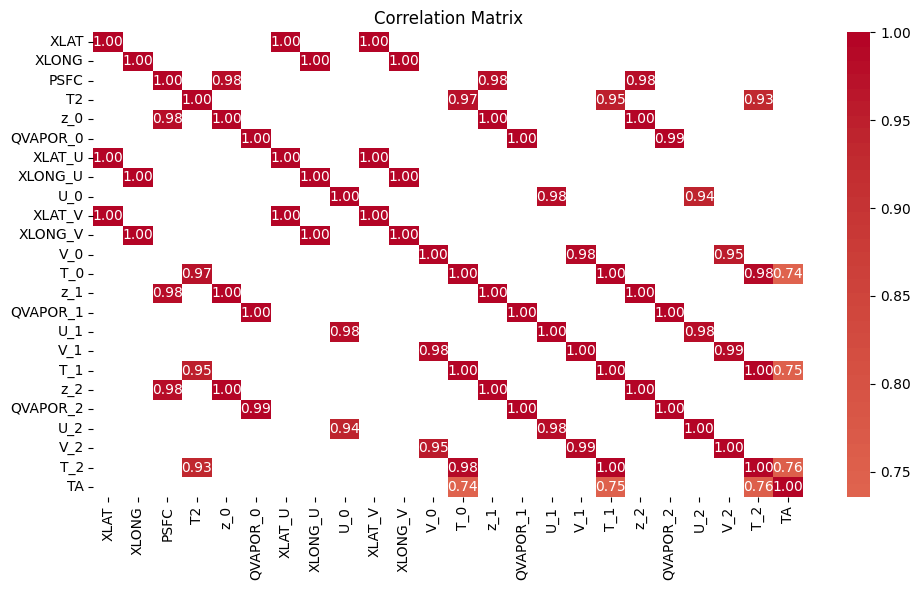

In [ ]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('DATA_v1.csv')
# Remove unnecessary columns for correlation analysis
df.drop(columns = ['id', 'hour', 'day', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'sea_percent'], inplace=True)
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 6))  
sns.heatmap(np.abs(corr_matrix), mask = np.abs(corr_matrix) < 0.7 , annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()



Above, we presented the correlation matrix for our variables. To keep the visualization clear, only correlation coefficients greater than 0.7 are shown. As expected, many variables exhibit strong correlations — for example:

T2, T_2, T_1, T_0

z_2, z_1, z_0, PSFC

QVAPOR_2, QVAPOR_1, QVAPOR_0

XLAT, XLAT_U, XLAT_V

XLONG, XLONG_U, XLONG_V

V_0, V_1, V_2

U_0, U_1, U_2

These high correlations are largely due to the physical nature of the variables. Most occur between the same parameter measured at different vertical levels — such as relative humidity (QVAPOR) or wind components (U, V). Since these levels are relatively close together in the atmosphere, their values tend to be very similar, resulting in strong inter-level correlations.

We first encountered this issue during model development, where a linear regression was strongly affected by multicollinearity — a condition in which predictor variables are highly linearly related. This led to inflated standard errors and unstable coefficient estimates. To address this, we reduced redundancy by selecting a single representative level for each group of correlated variables, which helped improve model stability and interpretability.

## Linear Regression

To better understand the influence of each variable on temperature, we performed a linear regression using the observed temperature as the target. This analysis helps identify which features have the strongest linear relationship with temperature, and serves as a useful reference when selecting input variables for a future neural network model.

Before fitting the model, we normalized all features to ensure that the regression coefficients were on a comparable scale and not biased by differing units. In this context, coefficients with larger absolute values indicate a stronger linear association with the target variable, while smaller coefficients suggest a weaker influence.

Below, we present a linear regression using all variables in the DataFrame to illustrate how multicollinearity affects the interpretation of coefficients

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('DATA_v1.csv').dropna()

X = df.drop(columns=['TA', 'id', 'datetime', 'day', 'hour'])
Y = df['TA'] + 273.15 # Kelvin

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LinearRegression()
model.fit(X_scaled, Y)
y_pred = model.predict(X_scaled)

r2 = r2_score(Y, y_pred)
print(f"R² global: {r2:.4f}")

fila = {
    'intercept': model.intercept_,
    'r2_score': r2,
    'Y-y_pred': np.mean(np.abs(Y - y_pred)),
    'Y-T2': np.mean(np.abs(Y - df['T2']))
}
for var_name, coef in zip(X.columns, model.coef_):
    fila[var_name] = coef

pd.set_option('display.max_columns', None)
df_result



R² global: 0.7532


,intercept,r2_score,Y-y_pred,Y-T2,XLAT,XLONG,PSFC,T2,z_0,QVAPOR_0,XLAT_U,XLONG_U,U_0,XLAT_V,XLONG_V,V_0,T_0,z_1,QVAPOR_1,U_1,V_1,T_1,z_2,QVAPOR_2,U_2,V_2,T_2,sea_percent,hour_sin,hour_cos,day_sin,day_cos
0,286.761588,0.753159,2.340914,3.467023,1846.41135,-737.695575,-0.942951,-0.930384,72.339654,-2.188639,-839.712726,1152.447514,-0.539145,-1006.714421,-414.539895,-0.019754,1.246548,-96.54284,1.552177,1.313597,0.579136,-4.310632,23.072167,2.059338,-1.057146,-0.766144,7.73961,0.081769,-1.542031,-1.677314,0.099613,0.145809


The first coefficient "intercept" is the indepent term of the polynomial expansion, whereas the "r2_score" indicates how well the linear regression predictions approximate the actual data points. The next two values "Y-y_pred" and "Y-T2" measure the absolute mean error of the linear model and the WRF model respectively.

The linear regression results reveal a number of important patterns, particularly in light of the multicollinearity identified earlier. Some spatial features such as XLAT, XLAT_U, and XLAT_V have very large coefficients, which reflects the underlying redundancy on our DataFrame. Interestingly, when summing the coefficients within these highly correlated groups with large coefficients, the net effect often reduces to a much smaller value, further illustrating the instability and redundancy caused by multicollinearity. 

The relatively high R² score (0.75) indicates that the model captures a considerable portion of the variance in temperature, but due to the instability of coefficients caused by highly correlated predictors, the individual weights should be interpreted with caution. This further justifies the decision to reduce feature dimensionality by selecting representative variables from each correlated group as we shall do next.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('DATA_v1.csv').dropna()

X = df.drop(columns=['TA', 'id', 'datetime', 'hour', 'day', 'XLAT', 'XLONG', 'QVAPOR_0', 'QVAPOR_1', 'z_0', 'z_1', 
                     'V_0', 'V_1', 'U_0', 'U_1', 'XLAT_U', 'XLAT_V', 'XLONG_U', 'XLONG_V', 'T_0', 'T_1']) 
Y = df['TA'] + 273.15

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LinearRegression()
model.fit(X_scaled, Y)
y_pred = model.predict(X_scaled)

results = {
    'datetime' : df['datetime'],
    'T2' : df['T2'],
    'y_pred' : y_pred,
    'Y' : Y
}
df_result = pd.DataFrame([results])
df_result.to_csv('results_linear_regression.csv', index=False)

fila = {
    'intercept': model.intercept_,
    'r2_score': r2_score(Y, y_pred),
    'Y-y_pred': np.mean(np.abs(Y - y_pred)),
    'Y-T2': np.mean(np.abs(Y - df['T2']))
}
for var_name, coef in zip(X.columns, model.coef_):
    fila[var_name] = coef

df_coeffs = pd.DataFrame([fila])
df_coeffs


,intercept,r2_score,Y-y_pred,Y-T2,PSFC,T2,z_2,QVAPOR_2,U_2,V_2,T_2,sea_percent,hour_sin,hour_cos,day_sin,day_cos
0,286.761588,0.750523,2.350958,3.467023,-0.84606,-1.237217,-1.00005,1.490022,-0.277689,-0.229816,4.780686,-0.010813,-1.54176,-1.677618,0.109517,0.151065


Despite significantly reducing the number of features in our DataFrame, the R² score remains virtually unchanged—indicating that the linear model still fits the data just as well as before. Moreover, the extremely large coefficients observed in the previous model have been successfully eliminated. As a result, the model now produces a more realistic and interpretable set of weights, offering a clearer representation of each variable's relationship with the targeted temperature. ------------------ANALYZE COEFFICIENTS-----PLOT INTRO--------------------------

## Analyzing the linear model

To conclude this section, we will analyze the performance of the linear model in comparison to the WRF model. At this stage, we can only compare the two using their mean absolute error (MAE), which is the only metric we have computed so far. Interestingly, the linear model appears to have a slightly lower MAE than the WRF model. This may seem surprising, considering we are comparing a simple linear regression from the scikit-learn library to a sophisticated and well-established weather forecasting system.

However, this apparent advantage is misleading. The linear model does not actually outperform the WRF model. Its seemingly better performance stems from the prevalence of average temperatures in our dataset. Since most recorded temperatures fall within a normal range, they are relatively easy for the linear model to predict. What the linear model lacks is the flexibility to capture extreme temperature events, which is precisely where the WRF model excels.

In reality, the WRF model is far more capable when it comes to forecasting temperature extremes—an essential requirement for meteorological agencies. The linear model, by its very nature, lacks the degrees of freedom needed to move beyond basic temperature predictions, as we will demonstrate below.

/tmp/ipykernel_4149/2616082183.py:79: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_error_mensual = df_diario.groupby('mes').apply(
/tmp/ipykernel_4149/2616082183.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=boxplot_data, x='Error Type', y='Absolute Error (°C)', palette='Set2')


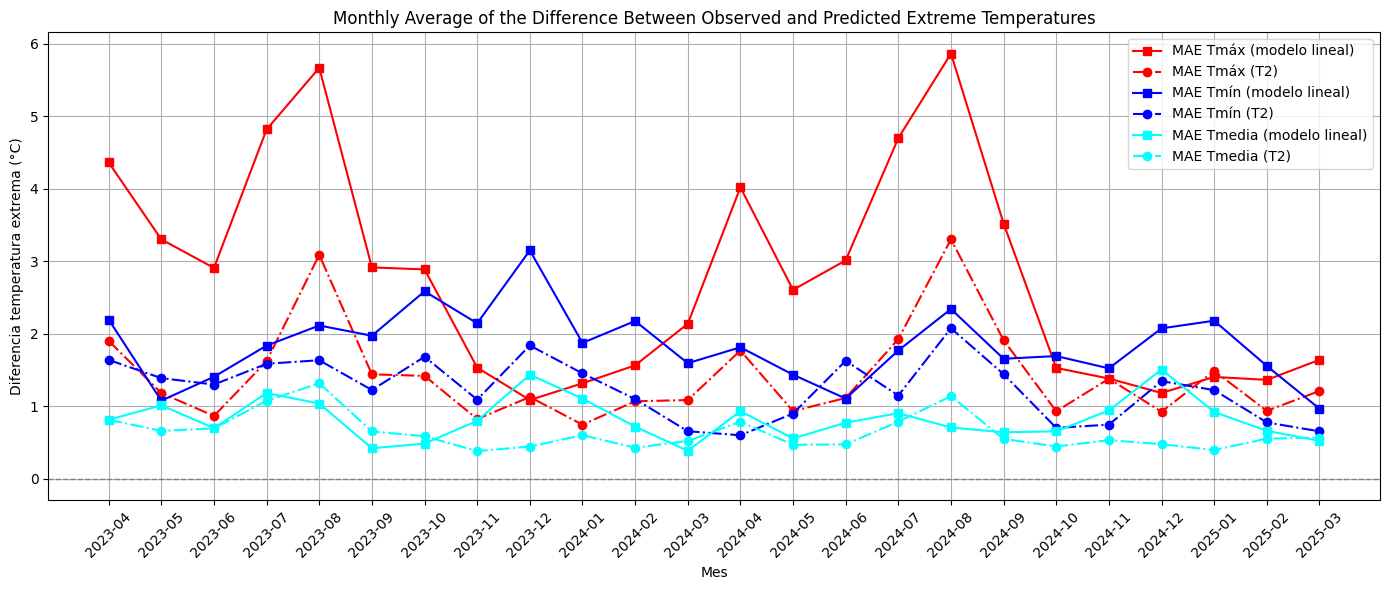

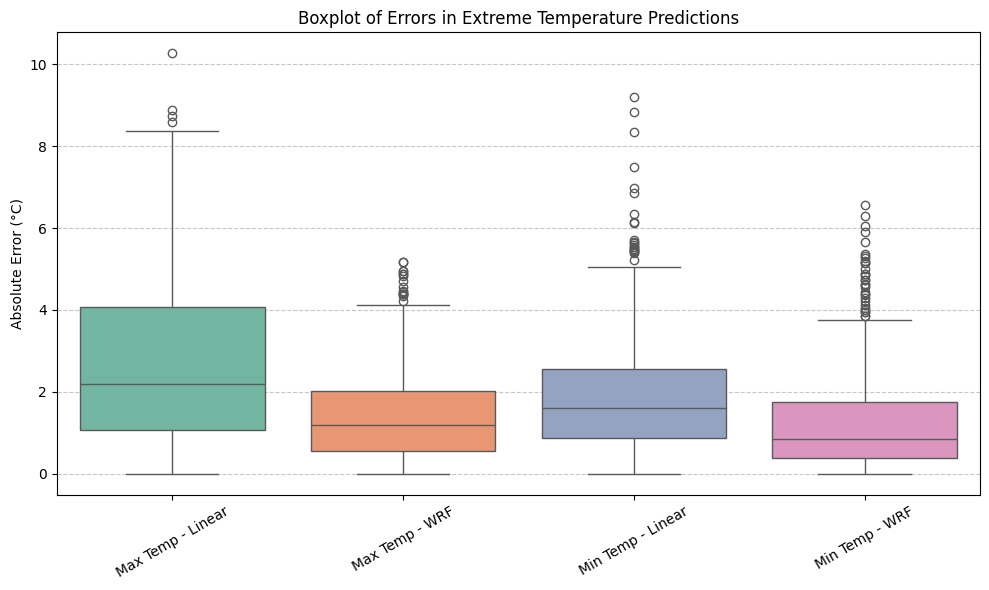

MAE linear model  2.351
MAE WRF : 3.467
MAE linear_max 2.7819682717688
MAE linear_min 1.8447716679643449
MAE WRF_max 1.4261434628204903
MAE WRF_min 1.2442910844281136


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('DATA_v1.csv').dropna()

X = df.drop(columns=['TA', 'id', 'datetime', 'hour', 'day', 'XLAT', 'XLONG', 'QVAPOR_0', 'QVAPOR_1', 'z_0', 'z_1', 
                     'V_0', 'V_1', 'U_0', 'U_1', 'XLAT_U', 'XLAT_V', 'XLONG_U', 'XLONG_V', 'T_0', 'T_1']) 
Y = df['TA'] + 273.15

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LinearRegression()
model.fit(X_scaled, Y)
y_pred = model.predict(X_scaled)

fila = {
    'intercept': model.intercept_,
    'r2_score': r2_score(Y, y_pred),
    'Y-y_pred': np.mean(np.abs(Y - y_pred)),
    'Y-T2': np.mean(np.abs(Y - df['T2']))
}
for var_name, coef in zip(X.columns, model.coef_):
    fila[var_name] = coef

df_result = pd.DataFrame([fila])
df_result.to_csv('Resultado_ajuste_global.csv', index=False)


# Plot 

df['fecha'] = pd.to_datetime(df['datetime'])
df['dia_fecha'] = df['fecha'].dt.normalize()
df['mes'] = df['fecha'].dt.to_period('M')

df['TA_C'] = df['TA']
df['y_pred_C'] = y_pred - 273.15
df['T2_C'] = df['T2'] - 273.15

# Extreme temperatures differences grouped by day

extremos_diarios = df.groupby('dia_fecha').agg({
    'TA_C': ['min', 'max'],
    'y_pred_C': ['min', 'max'],
    'T2_C': ['min', 'max'],
    'mes': 'first'
}).reset_index()

# Rename columns
extremos_diarios.columns = ['dia_fecha', 'TA_min', 'TA_max', 'y_pred_min', 'y_pred_max', 'T2_min', 'T2_max', 'mes']

# =============================== Errors on Extreme Cases =================================

extremos_diarios['diff_max_lin'] = np.abs(extremos_diarios['TA_max'] - extremos_diarios['y_pred_max'])
extremos_diarios['diff_max_T2'] = np.abs(extremos_diarios['TA_max'] - extremos_diarios['T2_max'])
extremos_diarios['diff_min_lin'] = np.abs(extremos_diarios['TA_min'] - extremos_diarios['y_pred_min'])
extremos_diarios['diff_min_T2'] = np.abs(extremos_diarios['TA_min'] - extremos_diarios['T2_min'])

# ======================================= Monthly =========================================

df_diffs_mensuales = extremos_diarios.groupby('mes')[[
    'diff_max_lin', 'diff_max_T2', 'diff_min_lin', 'diff_min_T2'
]].mean().reset_index()

# ================================ Dayly Mean absolute error ==============================

df_diario = df.groupby('dia_fecha').agg({ 
    'TA_C': 'mean',
    'y_pred_C': 'mean', 
    'T2_C': 'mean'
}).reset_index()

df_diario['mes'] = df_diario['dia_fecha'].dt.to_period('M')

df_error_mensual = df_diario.groupby('mes').apply(
    lambda x: pd.Series({
        'MAE_lin': np.mean(np.abs(x['y_pred_C'] - x['TA_C'])),
        'MAE_T2': np.mean(np.abs(x['T2_C'] - x['TA_C']))
    })
).reset_index()

# =============================== Merging monthly results =================================

df_mensual = df_diffs_mensuales.merge(df_error_mensual, on='mes') # AGRUPAMOS (df_diffs_mensuales) CON (df_error_mensual) POR MES 

# ========================================== Plot =========================================

plt.figure(figsize=(14, 6))

plt.plot(df_mensual['mes'].astype(str), df_mensual['diff_max_lin'], label='MAE Tmáx (modelo lineal)', marker='s', color='red')
plt.plot(df_mensual['mes'].astype(str), df_mensual['diff_max_T2'], label='MAE Tmáx (T2)',linestyle = '-.', marker='o', color='red')
plt.plot(df_mensual['mes'].astype(str), df_mensual['diff_min_lin'], label='MAE Tmín (modelo lineal)', marker='s', color='blue')
plt.plot(df_mensual['mes'].astype(str), df_mensual['diff_min_T2'], label='MAE Tmín (T2)', linestyle='-.', marker='o', color='blue')

plt.plot(df_mensual['mes'].astype(str), df_mensual['MAE_lin'], label='MAE Tmedia (modelo lineal)', marker='s', color='cyan')
plt.plot(df_mensual['mes'].astype(str), df_mensual['MAE_T2'], label='MAE Tmedia (T2)', linestyle='-.', marker='o', color='cyan')

plt.axhline(0, linestyle='--', color='gray', linewidth=1)

plt.xlabel('Mes')
plt.ylabel('Diferencia temperatura extrema (°C)')
plt.title('Monthly Average of the Difference Between Observed and Predicted Extreme Temperatures')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# ========================================== Boxplot ========================================

import seaborn as sns

# Prepare data for boxplot
boxplot_data = pd.melt(
    extremos_diarios,
    value_vars=['diff_max_lin', 'diff_max_T2', 'diff_min_lin', 'diff_min_T2'],
    var_name='Error Type',
    value_name='Absolute Error (°C)'
)

# Rename for clarity
boxplot_data['Error Type'] = boxplot_data['Error Type'].map({
    'diff_max_lin': 'Max Temp - Linear',
    'diff_max_T2': 'Max Temp - WRF',
    'diff_min_lin': 'Min Temp - Linear',
    'diff_min_T2': 'Min Temp - WRF'
})

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=boxplot_data, x='Error Type', y='Absolute Error (°C)', palette='Set2')

plt.title('Boxplot of Errors in Extreme Temperature Predictions')
plt.ylabel('Absolute Error (°C)')
plt.xlabel('')
plt.xticks(rotation=30)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#========================================== Prints ========================================

mae_lin_global = np.mean(np.abs(Y - y_pred))
mae_T2_global = np.mean(np.abs(Y - df['T2']))
print(f"MAE linear model  {mae_lin_global:.3f}")
print(f"MAE WRF : {mae_T2_global:.3f}")

print(f'MAE linear_max {np.mean(df_mensual["diff_max_lin"])}')
print(f'MAE linear_min {np.mean(df_mensual["diff_min_lin"])}')

print(f'MAE WRF_max {np.mean(df_mensual["diff_max_T2"])}')
print(f'MAE WRF_min {np.mean(df_mensual["diff_min_T2"])}')

plt.show()